# Generalized Linear Models using Pynapple & NeMos
In this notebook, we will use NeMos and Pynapple packages (supported by the [Flatiron Institute](https://neurorse.flatironinstitute.org)), to model spiking neural data using [Generalized Linear Models (GLM)](https://en.wikipedia.org/wiki/Generalized_linear_model). We will explain what GLMs are and which are their components, then use Pynapple and NeMos python packages to preprocess real data from the Allen Institute and use a GLM model to predict spiking neural data as a function of stimuli.

A GLM is a regression model which trains a filter to predict a value (output) as it relates to some other variable (or input). 

:::{admonition} Why are GLMs called GLMs?
:class: info
:class: dropdown

It is called "generalized" because it constitutes a generalization of [ordinary linear regression](https://en.wikipedia.org/wiki/Linear_regression). Ordinary linear regression assumes that a constant change in a predictor leads to a constant change in the response variable, but this assumption is no longer useful for some types of response variables. In particular, when interested in modeling spikes, these are never expected to be negative. Moreover, spikes do not vary in a constant manner (usually, the variance of spike counts changes with the mean firing rate: neurons with average higher firing rates tend to have a higher variability than neurons with average lower firing rates). Thus, if interested in modeling this kind of phenomena, the model of choice must account for these restrictions (:
:::



In the neuroscience context, we can use a particular type of GLM to predict spikes: linear-nonlinear-Poisson (LNP) model.
<figure>
<img src="lnp_model.svg" style="width:130%"/>
<figcaption align = "center"> LNP model schematic. Modified from <a href="https://www.nature.com/articles/nature07140">Pillow et al., 2008</a></figcaption>
</figure>
 That is, the model receives one or more inputs and then:

1. Sends them through a linear filter or transformation

    The input (s) (also known as "predictor(s)") are first passed through a linear transformation: 
    
    $WX + c$

    This scales (makes bigger or smaller) or shifts (up or down) the input. When there is zero input, this is equivalent to changing the baseline rate of the neuron, which is how the intercept should be interpreted. So far, this is the same treatment of an ordinary linear regression. 

2. Passes the transformation through a nonlinearity to obtain a firing rate.
    
    The aim of a GLM is to predict spiking activity. In particular, to predict a neuron's firing rate, which must be non-negative. This, as mentioned, is what the non-linearity part of the model handles: by passing the linear transformation through an exponential function, it is assured that it will always be non-negative. 

    As such, the firing rate, according to GLMs, would be defined as:

    $\lambda =  exp(WX + c)$


:::{admonition} A note on non-linearity
:class: info
:class: dropdown


In NeMoS, the non-linearity is kept fixed. We default to the exponential, but a small number of other choices, such as soft-plus, are allowed. The allowed choices guarantee both the non-negativity constraint described above, as well as convexity, i.e. a single optimal solution. In principle, one could choose a more complex non-linearity, but convexity is not guaranteed in general.
:::

3. Uses the firing rate as the mean of a Poisson process to generate spikes

    A Poisson process is a special type of point process, in which the events are statistically independent. With these type of GLMs, each spike train is a sample from a Poisson process with the mean equal to the firing rate, i.e., output of the linear-nonlinear parts of the model. 

    Remember, spiking is a stochastic process. That means that a given firing rate can give rise to a variety of different spike trains. Given that this is a stochastic process that could produce an infinite number of possible spike trains, how do we compare our model against the single observed spike train we have? We use the log-likelihood. This quantifies how likely it is to observe the given spike train for the computed firing rate: if $y(t)$ is the spike counts and $\lambda(t)$ the firing rate, the equation for the log-likelihood is

    $\sum_{t}logP(y(t)|\lambda(t) = \sum_{t}y(t)log(\lambda(t))) - \lambda(t) - log(y(t)!)$

:::{admonition} More resources
:class: seealso
:class: dropdown

If you would like to learn more in depth about GLMs, you can refer to:

- [Nemos GLM tutorial](https://nemos.readthedocs.io/en/latest/background/plot_00_conceptual_intro.html): for a bit more detailed explanation of all the components of a GLM within the NEMOS framework, as well as some nice visualizations of all the steps of the input transformation!
- [Youtube video on LNP](https://www.youtube.com/watch?v=i62gffPrZYA): Although outside of the context of Neuroscience, it does go step by step explaining what LNPs are with visualizations and notes on limitations of the model (:
:::


We will be analyzing data from the [Visual Coding - Neuropixels dataset](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels), published by the Allen Institute. This dataset uses [extracellular electrophysiology probes](https://www.nature.com/articles/nature24636) to record spikes from multiple regions in the brain during passive visual stimulation. For simplicity, we will focus on the activity of neurons in the visual cortex (VISp) during passive visual stimulation: full-field flashes, of color either black or white. 

Our aim is to model spiking activity from neurons (spiking rates and spike trains) from the Primary Visual cortex (VISp) as a function of the presented visual stimuli. Moreover, we will also compare this model including an extra predictor: spike history, to see whether adding history as a predictor improves the performance of the model.

### Create Environment and Import Libraries

In [1]:
'''
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

'''

'\ntry:\n    from databook_utils.dandi_utils import dandi_download_open\nexcept:\n    !git clone https://github.com/AllenInstitute/openscope_databook.git\n    %cd openscope_databook\n    %pip install -e .\n\n'

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pynapple as nap
import nemos as nmo
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib.ticker import MaxNLocator

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5, rc=custom_params)

### Download data

In [4]:
# Dataset information
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

# Download 
# io = nmo.fetch.download_dandi_data(dandiset_id, dandi_filepath)
# nap_nwb = nap.NWBFile(io.read(), lazy_loading=True)

Now that we have downloaded the data, it is very simple to open the dataset with Pynapple

In [5]:
path = "sub-726298249_ses-754829445.nwb"
data = nap.load_file(path)
nwb = data.nwb

print(data)

sub-726298249_ses-754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ runn

:::{admonition} Pynapple objects
:class: info
:class: dropdown

Here we can see four type of Pynapple objects:
- TsGroup : Dictionary-like object to group objects with different timestamps 
- IntervalSet : A class representing a (irregular) set of time intervals in elapsed time, with relative operations
- Tsd : 1-dimensional container for neurophysiological time series - provides standardized time representation, plus various functions for manipulating times series.
- TsdFrame : Column-based container for neurophysiological time series

To learn more, please refer to the [Pynapple documentation](https://pynapple.org)
:::

## Extraction, preprocessing and stimuli revision

### Extracting Spiking Data

We have a lot of information in ```data```, but we are interested in the units.

:::{admonition} Why call them "units" instead of neurons?
:class: info
:class: dropdown

Throughout the Allen Software Development Kit (Allen SDK), neurons are referred to as "units" because there is no guarantee that the spikes assigned from one unit originate from that single cell. For more information, please refer to the [Allen SDK website](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html)

:::

In [6]:
units = data["units"]

# See the columns
print(f"columns : {units.metadata_columns}")

# See the dataset
print(units)

columns : ['rate', 'spread', 'velocity_below', 'silhouette_score', 'firing_rate', 'd_prime', 'nn_hit_rate', 'waveform_duration', 'amplitude', 'cluster_id', 'snr', 'local_index', 'peak_channel_id', 'PT_ratio', 'presence_ratio', 'max_drift', 'cumulative_drift', 'repolarization_slope', 'waveform_halfwidth', 'amplitude_cutoff', 'nn_miss_rate', 'quality', 'velocity_above', 'isolation_distance', 'l_ratio', 'recovery_slope', 'isi_violations']
Index      rate      spread    velocity_below    silhouette_score    firing_rate    d_prime    nn_hit_rate    ...
---------  --------  --------  ----------------  ------------------  -------------  ---------  -------------  -----
951763702  2.38003   30.0      nan               nan                 2.38           4.77       0.98           ...
951763707  0.01147   80.0      nan               0.03                0.01           3.48       0.0            ...
951763711  3.1503    50.0      nan               0.17                3.15           6.08       1.0    

Taking a closer look at the columns, we can see there is a lot of information we do not need. We are solely interested in predicting the rate and spiking activity from the neurons from VISp. Thus, we will remove the metadata from all columns except for rate, quality (to make sure we filter the bad-quality neurons) and peak_channel_id (this last one contains relevant information for brain area identification).

In [7]:
def drop_cols(cols_to_keep, data):
    print(f"Previous columns {data.metadata_columns}")
    cols_to_remove = [col for col in data.metadata_columns if col not in cols_to_keep]
    data.drop_info(cols_to_remove)
    print(f"New columns after drop {data.metadata_columns}")

In [8]:
# Choose which columns to remove and remove them
cols_to_keep = ['rate', 'quality','peak_channel_id']
drop_cols(cols_to_keep,units)

# See the dataset
print(units)

Previous columns ['rate', 'spread', 'velocity_below', 'silhouette_score', 'firing_rate', 'd_prime', 'nn_hit_rate', 'waveform_duration', 'amplitude', 'cluster_id', 'snr', 'local_index', 'peak_channel_id', 'PT_ratio', 'presence_ratio', 'max_drift', 'cumulative_drift', 'repolarization_slope', 'waveform_halfwidth', 'amplitude_cutoff', 'nn_miss_rate', 'quality', 'velocity_above', 'isolation_distance', 'l_ratio', 'recovery_slope', 'isi_violations']
New columns after drop ['rate', 'peak_channel_id', 'quality']
Index      rate      peak_channel_id    quality
---------  --------  -----------------  ---------
951763702  2.38003   850135036          good
951763707  0.01147   850135036          noise
951763711  3.1503    850135038          good
951763715  6.53      850135038          good
951763720  2.00296   850135044          good
951763724  8.66233   850135044          noise
951763729  11.13402  850135044          noise
...        ...       ...                ...
951777559  0.02108   850139336 

Here we dont have the brain area information but we need it, so we need to do some preprocessing to extract brain area from the peak_channel_id metadata

In [9]:
# Units and brain areas those units belong to are in two different places. With the electrodes table, we can map units to their corresponding brain regions.
def get_unit_location(unit_id):
    """Aligns location information from electrodes table with channel id from the units table
    """
    return channel_probes[int(units[unit_id].peak_channel_id)]

channel_probes = {}
electrodes = nwb.electrodes

for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# Add a new column to include location in our spikes TsGroup
units.brain_area = [channel_probes[int(ch_id)] for ch_id in units.peak_channel_id]

# Remove peak_channel_id because we already got the brain_area information
units.drop_info("peak_channel_id")

print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951763702  2.38003   good       PoT
951763707  0.01147   noise      PoT
951763711  3.1503    good       PoT
951763715  6.53      good       PoT
951763720  2.00296   good       PoT
951763724  8.66233   noise      PoT
951763729  11.13402  noise      PoT
...        ...       ...        ...
951777559  0.02108   good       LP
951777565  0.08143   noise      DG
951777571  0.20088   good       VISpm
951777576  0.01085   good       LP
951777582  0.1457    good       CA1
951777593  0.0464    good       CA1
951777600  0.0621    good       CA1


### Extracting stimulus data

In [10]:
# Extract flashes
flashes = data["flashes_presentations"]

# Remove unnecesary columns, similarly to above
cols_to_keep = ['color']
drop_cols(cols_to_keep, flashes)

print(flashes)

Previous columns ['stimulus_name', 'stimulus_block', 'color', 'mask', 'opacity', 'phase', 'size', 'units', 'stimulus_index', 'orientation', 'spatial_frequency', 'contrast', 'tags', 'timeseries']
New columns after drop ['color']
index    start           end             color
0        1285.600869922  1285.851080039  -1.0
1        1287.602559922  1287.852767539  -1.0
2        1289.604229922  1289.854435039  -1.0
3        1291.605889922  1291.856100039  -1.0
4        1293.607609922  1293.857807539  1.0
5        1295.609249922  1295.859455039  -1.0
6        1297.610959922  1297.861155039  1.0
...      ...             ...             ...
143      1571.840009922  1572.090212539  -1.0
144      1573.841669922  1574.091877539  1.0
145      1575.843359922  1576.093562539  1.0
146      1577.845019922  1578.095227539  -1.0
147      1579.846709922  1580.096915039  1.0
148      1581.848389922  1582.098595039  1.0
149      1583.850039922  1584.100247539  -1.0
shape: (150, 2), time unit: sec.


In [11]:
# Create an object for white and a separate object for black flashes
flashes_white = flashes[flashes["color"] == "1.0"]
flashes_black = flashes[flashes["color"] == "-1.0"]

### Preprocessing Spiking Data

There are multiple reasons for filtering units. Here, we will use three criteria: brain area, quality of units, firing rate and responsiveness
1. Brain area: we are interested in analyzing VISp units for this tutorial
2. Quality: we will only select "good" quality neurons
3. Firing rate: overall, we want neurons with a firing rate larger than 2 throughout all recordings
4. Responsiveness: Since the goal is to predict firing rate as a function of stimuli, we are now specifically interested in how neurons respond to white and/or black flashes. To focus on meaningful signal, we will (1) exclude units that show no spiking activity during stimulus presentation. Additionally, (2) we will select the most responsive units (top 30% responsiveness), and only use those for further analysis. We define responsiveness as the normalized difference between post stimulus and pre stimulus average firing rate.

:::{admonition} More information on quality assessment
:class: info
:class: dropdown

More information on unit quality metrics can be found in [Visualizing Unit Quality Metrics ](../visualization/visualize_unit_metrics.ipynb)

:::

:::{admonition} Responsiveness
:class: info
:class: dropdown

post_stim_av  : 
    Average firing rate during presentation (250ms) of stimulus across
    all instances of stimulus. 

pre_stim_av :
    Average firing rate prior (250ms) to the presentation of stimulus
    accross all instances prior of stimulus. 

responsiveness : 
    (post_stim_ave - pre_stim_av) / (post_stim_ave + pre_stim_av)

Larger values indicate higher responsiveness to the stimuli.
:::

In [12]:
# Initially, filter units 1) in VISp, 2) with "good" quality and 3) with a firing rate larger than 2
units = units[(units["brain_area"]=="VISp") & (units["quality"]=="good") & (units["rate"]>2.0)] 

print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951765440  9.97935   good       VISp
951765454  5.47349   good       VISp
951765460  4.44892   good       VISp
951765467  9.98162   good       VISp
951765478  17.40465  good       VISp
951765485  13.97731  good       VISp
951765508  2.13461   good       VISp
...        ...       ...        ...
951768894  9.16155   good       VISp
951768901  3.99186   good       VISp
951768907  2.85765   good       VISp
951768925  2.28806   good       VISp
951769295  3.27275   good       VISp
951769299  4.57933   good       VISp
951769304  2.04729   good       VISp


Now, to calculate responsiveness, we need to do some preprocessing to re-center time series and timestamps data around a particular event (perievent), as well as computing average spike rate.

In [13]:
min_peri = -.250 # Explain what these values are
max_peri = .250

peri_white = nap.compute_perievent(timestamps = units,
                                        tref = flashes_white.starts,
                                        minmax = (min_peri, max_peri)
)

peri_black = nap.compute_perievent(timestamps = units,
                                        tref = flashes_black.starts,
                                        minmax = (min_peri, max_peri)
)

In [14]:
def get_responsiveness(perievents, bin_sz):
    """Calculate responsiveness for each neuron. This is
    computer as:

    post_stim_av  : 
        Average firing rate during presentation (250ms) of stimulus across
        all instances of stimulus. 

    pre_stim_av :
        Average firing rate prior (250ms) to the presentation of stimulus
        accross all instances prior of stimulus. 

    responsiveness : 
        (post_stim_ave - pre_stim_av) / (post_stim_ave + pre_stim_av)

    Larger values indicate higher responsiveness to the stimuli.
        
    Parameters
    ----------
    perievents : TsGroup
        Contains perievent information of a subset of neurons
    bin_sz : float
        Bin size for calculating spike counts

    Returns
    ----------   
    resp_array : np.array
        Array of responsiveness information.
    resp_dict : dict
        Dictionary of responsiveness information. Indexed by each neuron's,
        contains responsiveness, pre_stim_av and post_stim_av information

    """
    resp_dict = {}
    resp_array = np.zeros(len(perievents.keys()), dtype=float)

    for index,unit in enumerate(perievents.keys()):
        # Count the number of timestamps in each bin_sz bin.
        peri_counts = perievents[unit].count(bin_sz)

        # Get the firing rate
        peri_rate = peri_counts/bin_sz

        # Compute average firing rate for each milisecond in the
        # the 250ms before stimulus presentation
        pre_stim = np.mean(peri_rate,1)[:25]

        # Compute average firing rate for each milisecond in the
        # the 250ms after stimulus presentation
        post_stim = np.mean(peri_rate,1)[25:50]

        pre_stim_av = np.mean(pre_stim)
        post_stim_av = np.mean(post_stim)
        responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)

        resp_dict[unit] = {
            "responsiveness": responsiveness,
            "pre_stim_av": pre_stim_av,
            "post_stim_av": post_stim_av,
        }
        resp_array[index] = responsiveness

    return resp_array, resp_dict

- Set START and END of analysis as start and end of stimuli. This dataset originally contained a lot more information of different stimuli, which is why the recording of spikes is a lot longer than flashes presentation. However, we are only interested in seeing the effect of white and black flashes in neural activity. 
- BIN_SIZE refers to the size of the "binning" of the time series. In that sense, a BIN_SIZE of 0.01 means that one second will be split into 100 bins. Larger bins indicate less temporal resolution, while smaller bins indicate larger temporal resolution.

In [15]:
bin_sz = 0.01

responsiveness_white,_ = get_responsiveness(peri_white, bin_sz)
responsiveness_black,_ = get_responsiveness(peri_black, bin_sz)

In [16]:
# Tried to set it with dictionary but couldnt
# Checked first few and last few to revise whether they were the same order
# How could I be sure 100%?

units.set_info(responsiveness_white=responsiveness_white)
units.set_info(responsiveness_black=responsiveness_black)

In [17]:
# First, I'd need to remove nan values, those are precisely the units without any
# firing throughout the stimulus presentation
units = units[~np.isnan(units["responsiveness_black"]) & ~np.isnan(units["responsiveness_white"])]

# Get threshold for top 30% most resopnsive
thresh_black = np.percentile(units["responsiveness_black"], 70)
thresh_white = np.percentile(units["responsiveness_white"], 70)

# Only keep units that are within the 30% most responsive for either black or white
units = units[(units["responsiveness_black"] > thresh_black) | (units["responsiveness_white"] > thresh_white)]

### Revision of stimuli and spiking

In [18]:
def raster_plot(units, n_neurons = len(units), n_flashes = 5, n_seconds = 13, offset = .5):
    n_neurons = len(units)
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset # Start a little bit earlier than the first flash presentation
    end = start + n_seconds

    # Restrict the neurons to the period of presentation of plotted stimuli
    units = units.restrict(nap.IntervalSet(start, end))

    # Change type to tsd to access spiking times. 
    # Change the metadata information so each different neuron is now tagged with an ID from 1 to 10
    neurons_to_plot = units.to_tsd([i+1 for i in range(n_neurons)])

    fig, ax = plt.subplots(figsize = (17, 4))

    ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

    # Different coloured flashes
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]


    plt.xlabel("Time (s)")
    plt.ylabel("Unit")
    ax.set_title("Primary Visual Cortex (VISp) units spikes and stimuli")
    
    plt.xlim(start,end) # Note to Guillaume: cant remove xlim because if i do the plot looks weird at the beginning as if there was no spiking

    # Only use integer values for ticks
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()

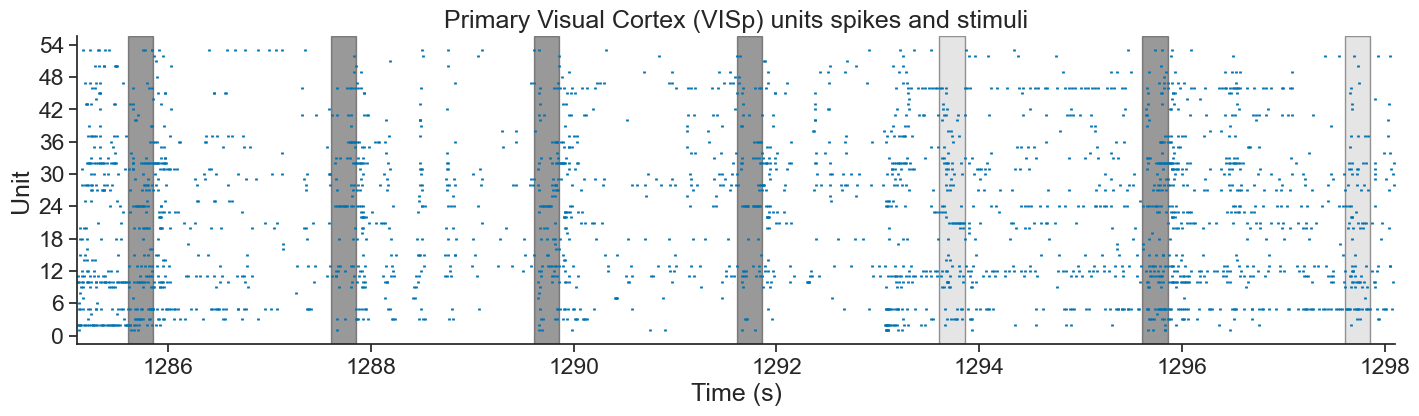

In [19]:
raster_plot(units)

The plot above takes the average spike rate across trials, while the plot below shows each trial spike rate. A trial is to be interpreted as an instance of stimulus presentation

In [20]:
def plot_raster_peth(): # comment
    n_cols = 7
    n_rows = 2
    fig, ax = plt.subplots(n_rows,n_cols)
    fig.set_figheight(5)
    fig.set_figwidth(17)
    fig.tight_layout()

    units_list = list(peri_white.keys())

    start = 0
    end = int(n_rows / 2)
    for col in range(n_cols):
        for i, unit in enumerate(units_list[start:end]):
            u = peri_white[unit]

            ax[2*i,col].plot(np.mean(u.count(0.01), 1) / 0.01, linewidth=2, color="red")
            ax[2*i,col].axvline(0.0)
            ax[2*i,col].set_ylim(0,50)
            ax[2*i,col].set_title(f'{unit}')

            ax[2*i+1,col].plot(u.to_tsd(), "|", markersize=1, color="red", mew=4)
            ax[2*i+1,col].axvline(0.0)
            ax[2*i+1,col].set_ylim(0,70)
            start+=1
            end+=1
    ax[0,0].set_ylabel("Rate (Hz, all)")
    ax[1,0].set_ylabel("Rate (Hz, single trial)")
    fig.text(0.5, 0.00, 'Time from stim(s)', ha='center')
    fig.text(0.5, 1.00, 'Peri-event histogram - white flashes', ha='center')

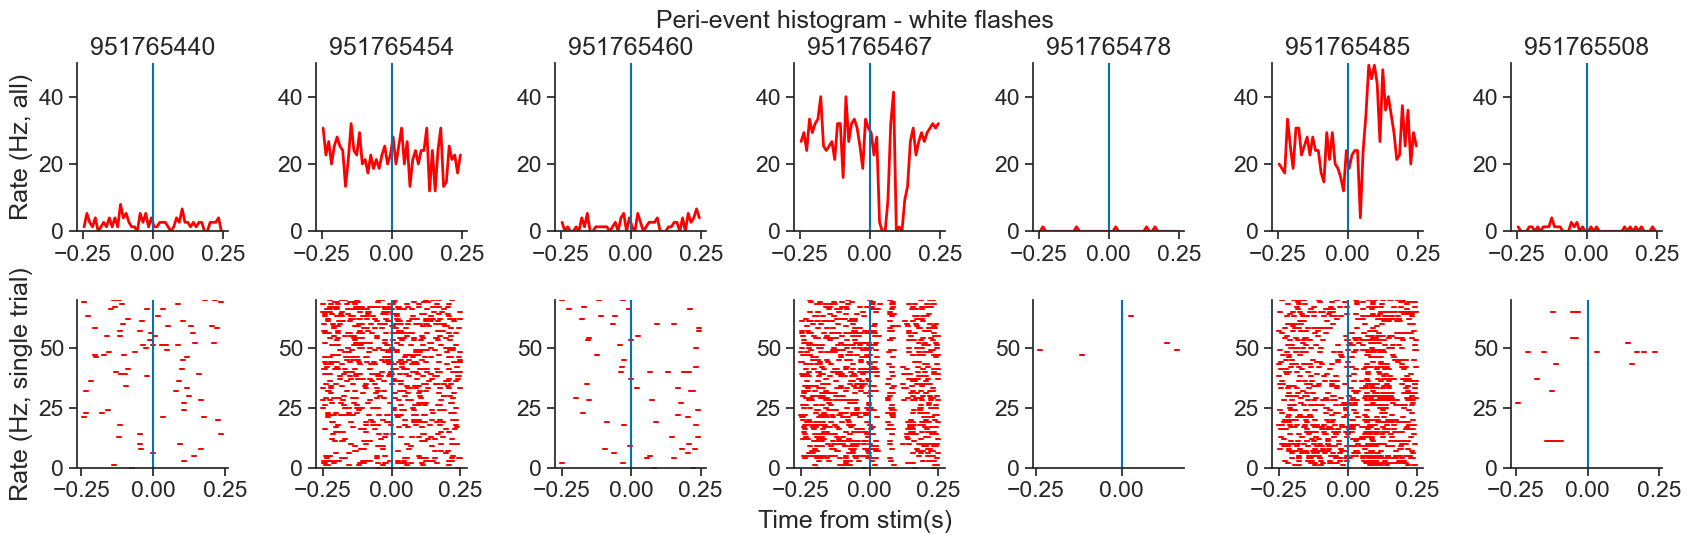

In [21]:
plot_raster_peth()
# plot black as well

Here we see peri-event time histograms (PETHs) and corresponding raster plots for seven different units, aligned to stimulus presentation at time zero. Some units show clear, time-locked responses to the stimulus. For instance, units 951765467 and 951765485 display sharp increases in firing rate immediately after the event, with consistent spike timing across trials — a strong indication of stimulus responsiveness.

In contrast, other units appear less driven by the stimulus. Unit 951765454, for example, maintains a relatively steady firing rate both before and after the event, suggesting that its activity may reflect ongoing processes like arousal or spontaneous firing rather than a direct response to the stimulus.

In [22]:
## Plot definition side by side
def plot_peri_side_by_side(params,
                           bin_sz,
                           simulation = False,
                           smoothing = 0.02,
                           ):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white, peri_black = params

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    for unit in list(peri_white.keys()):
        if simulation and not hist: 
            peri_u = np.mean(peri_white,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_white[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)
    

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    # Plot Black
    ax = axs[1]
    for unit in list(peri_black.keys()):
        if simulation: 
            peri_u = np.mean(peri_black,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_black[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")

    plt.tight_layout()
    plt.show()


We can also plot all perievents together, to get a sense of all neurons activity (?)

In [23]:
# For responsiveness, I calculated .250 before and .250 after.
# For plot, I am calculating .250 before and 500 after, just so it looks pretty - okay?

min_peri = -.250 # Explain what these values are
max_peri = .500

peri_white_500 = nap.compute_perievent(timestamps = units,
                                        tref = flashes_white.starts,
                                        minmax = (min_peri, max_peri)
)

peri_black_500 = nap.compute_perievent(timestamps = units,
                                        tref = flashes_black.starts,
                                        minmax = (min_peri, max_peri)
)

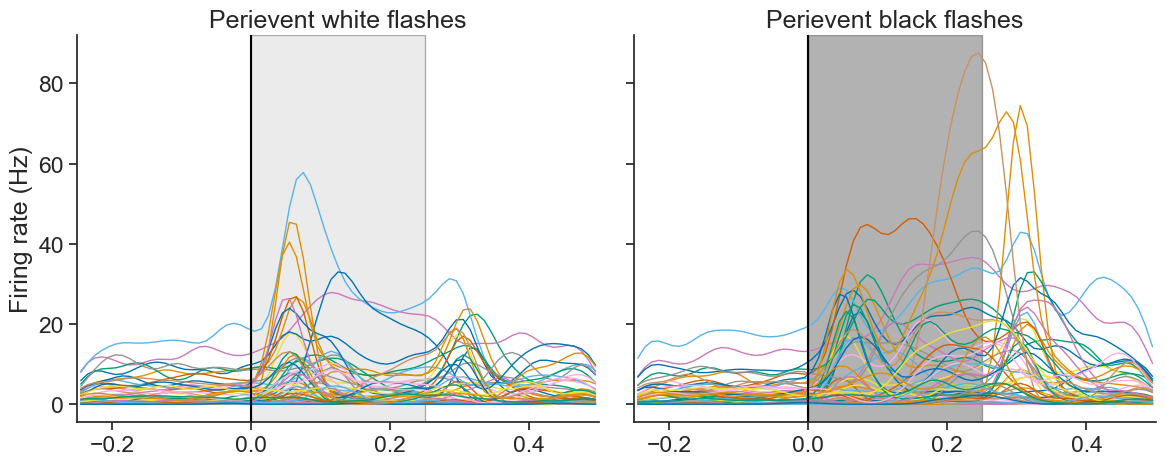

In [24]:
# check transparency of plot line axvspan
bin_size = 0.01

params_obs = [peri_white_500, 
              peri_black_500]

plot_peri_side_by_side(params_obs,
                       bin_size
)

These neurons spiking rate certainly seems modulated by the flashes presentation.

Here I would put an explanation for the duration of the filter. Id actually say that maybe the filter should be a bit longer? at least according to the perievent plots. 

### Splitting the dataset in train and test

It is good practice to split the data in two chunks: training and testing data. The first chunk is used to train the model; the second, to asses its performance. The reason why we do this is to accurately assess the performance of the model. If we train and evaluate the model in the same data, this results in a biased  model which will yield high accuracy in the dataset it was trained with, which won't be representative of it's performance on any other dataset.

This splitting can be done in different ways. Here, we will split the data in training (70%) and testing (30%). For that, first we want to take all instances of flash presentation, and gather 250ms before their presentation, and 250ms after they have concluded. Then, we will split them in black and white, and gather one every two flashes. 

We do not want to grab 70% first presentations and then last 30% because what if we are biasing our sample and there are some neurons that respond only towards the end or the beginning of the experiment? For that, we will gather one every three flashes, and those will go to the testing set. The rest, will go to the training set.

In [25]:
dt = .25
start = flashes.start - dt
end = flashes.end + dt

new_flashes = nap.IntervalSet(start,end, metadata=flashes.metadata)
new_flashes_white = new_flashes[new_flashes["color"]=="1.0"]
new_flashes_black = new_flashes[new_flashes["color"]=="-1.0"]

In [26]:
flashes_test_white = new_flashes_white[::3]
flashes_train_white = new_flashes_white.set_diff(flashes_test_white)

flashes_test_black = new_flashes_black[::3]
flashes_train_black = new_flashes_black.set_diff(flashes_test_black)

In [27]:
# Bin size for counting spikes
bin_sz = 0.01 

# Merge both stimuli types in a single interval set to be able to restrict units
flashes_test = flashes_test_white.union(flashes_test_black)
flashes_train = flashes_train_white.union(flashes_train_black)

units = units.restrict(flashes_test.union(flashes_train))

# Restrict time intervals according to subgroup (train or test)
units_test = units.restrict(flashes_test)
units_train = units.restrict(flashes_train)

# get counts
units_counts_test = units_test.count(bin_sz)
units_counts_train = units_train.count(bin_sz)

Just a one more preprocessing steps left to go!

For modeling, we need the flashes to be in the same bin size as the spikes. At the moment, the flashes are in a IntervalSet, we need to grab them and make them time series of stimuli, separated by black and white (because we are interested in how neurons' responses are modulated by each separately).

In [28]:
# General spike counts, in 0.01 bins
units_counts = units.count(bin_sz)

# Create a ts frame filled by zeros, for the size of units_counts
predictors = nap.TsdFrame(t=units_counts.t, d=np.zeros((len(units_counts), 2)), columns = ['white', 'black'])

# Check whether there is a flash within a given bin of spikes
# If there is not, put a nan in that index
idx_white = flashes_white.in_interval(units_counts)
idx_black = flashes_black.in_interval(units_counts)

# Replace everything that is not nan with 1 in the corresponding column
predictors.d[~np.isnan(idx_white), 0] = 1
predictors.d[~np.isnan(idx_black), 1] = 1

Just to make sure that we got the right output, let's plot our new "predictors" time series alongside our first plot

In [29]:
def stimuli_plot(units, predictors, n_neurons = len(units), n_flashes = 5, n_seconds = 13, offset = .5):
    n_neurons = len(units)
    n_flashes = 20
    n_seconds = 30
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset # Start a little bit earlier than the first flash presentation
    end = start + n_seconds


    fig, ax = plt.subplots(figsize = (17, 4))

    #ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

    # Different coloured flashes
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]
    plt.plot(predictors["white"], ".", color= "silver")
    plt.plot(predictors["black"], ".", color= "black")


    plt.xlabel("Time (s)")
    plt.ylabel("Absent = 0, Present = 1")
    ax.set_title("Presented Stimuli")
    
    plt.xlim(start,end) # Note to Guillaume: cant remove xlim because if i do the plot looks weird at the beginning as if there was no spiking

    # Only use integer values for ticks
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()


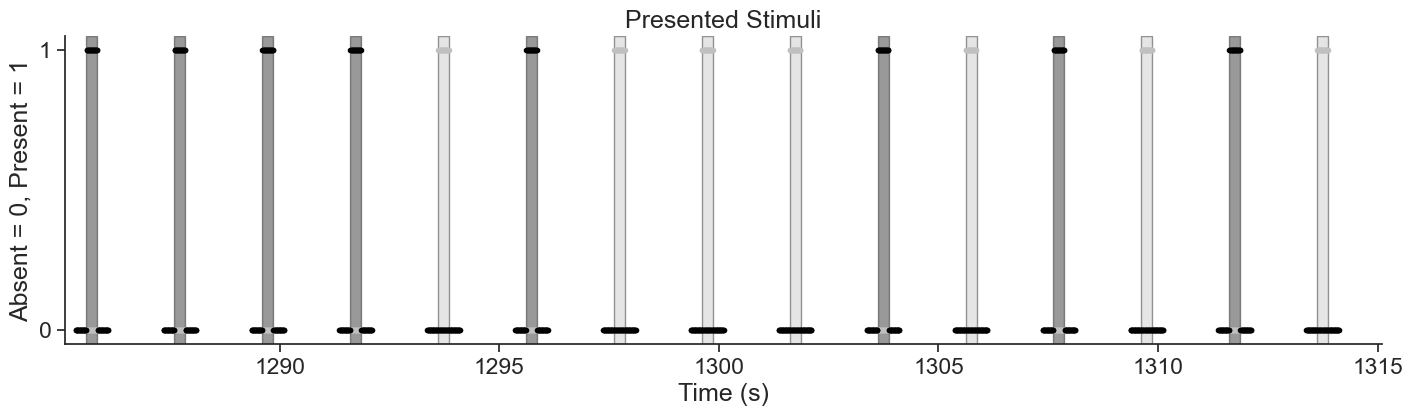

In [30]:
stimuli_plot(units, predictors)

They match perfectly! As a last step, let's just split these predictors in train and test to move to building a basis (:

In [31]:
predictors_test = predictors.restrict(units_test.time_support)
predictors_train = predictors.restrict(units_train.time_support)

## Fitting a GLM

### Creation of a basis
Have to explain why I am using:
- Raised Cosine Log
- Conv

place cells tutorial for explanation of composition of bases

In [32]:
# Create basis for training
bin_sz = 0.01
window_length = int(0.25 / bin_sz)

bas = nmo.basis.RaisedCosineLogConv(n_basis_funcs = 5, window_size = window_length, label = "w") + nmo.basis.RaisedCosineLogConv(n_basis_funcs = 5, window_size = window_length, label = "b")

X_train = bas.compute_features(predictors_train["white"], predictors_train["black"])
X_test = bas.compute_features(predictors_test["white"], predictors_test["black"])

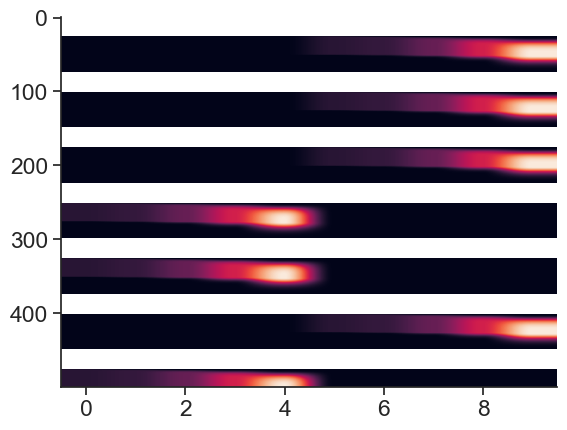

In [33]:
plt.imshow(X_train.values[:500], aspect="auto")

### Fit a PopulationGLM


In [34]:
reg_strength = 0.01 #This should be checked with cross validation

model_base = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = reg_strength,
    solver_name="LBFGS", 
    solver_kwargs=dict(tol=10**-12))

model_base.fit(
    X_train,
    units_counts_train
)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.01,
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

## Nemos: evaluating GLM
To assess whether the glm captures the data, let's predict spike rates.

I'll plot the rates in a perievent time histogram, so we can see whether the activity matches the observed patterns

### Perievent

In [35]:
pred_pop = model_base.predict(X_test)

# convert units from spikes/bin to spikes/sec
pred_pop = pred_pop/ bin_size

In [36]:
min_peri = -.25
max_peri = .50 # Stimulus presentation is at .25 and lasts until .50


peri_white_pred = nap.compute_perievent_continuous(timeseries = pred_pop, 
                                        tref = nap.Ts(flashes_test_white.start+.25),
                                        minmax=(min_peri, max_peri)
)  

peri_black_pred =  nap.compute_perievent_continuous(timeseries = pred_pop, 
                                        tref = nap.Ts(flashes_test_black.start+.25),
                                        minmax=(min_peri, max_peri)
)  

params_pred = [peri_white_pred,
              range(peri_white_pred.shape[2]),
              peri_black_pred,
              range(peri_black_pred.shape[2])
]

In [40]:
peri_white_test = nap.compute_perievent(timestamps = units_test,
                                        tref = nap.Ts(flashes_test_white.start+.25),
                                        minmax = (min_peri, max_peri)
)

peri_black_test = nap.compute_perievent(timestamps = units_test,
                                        tref = nap.Ts(flashes_test_black.start+.25),
                                        minmax = (min_peri, max_peri)
)


params_obs_test = [peri_white_test,
                   list(peri_white_test.keys()),
                   peri_black_test,
                   list(peri_black_test.keys())
]

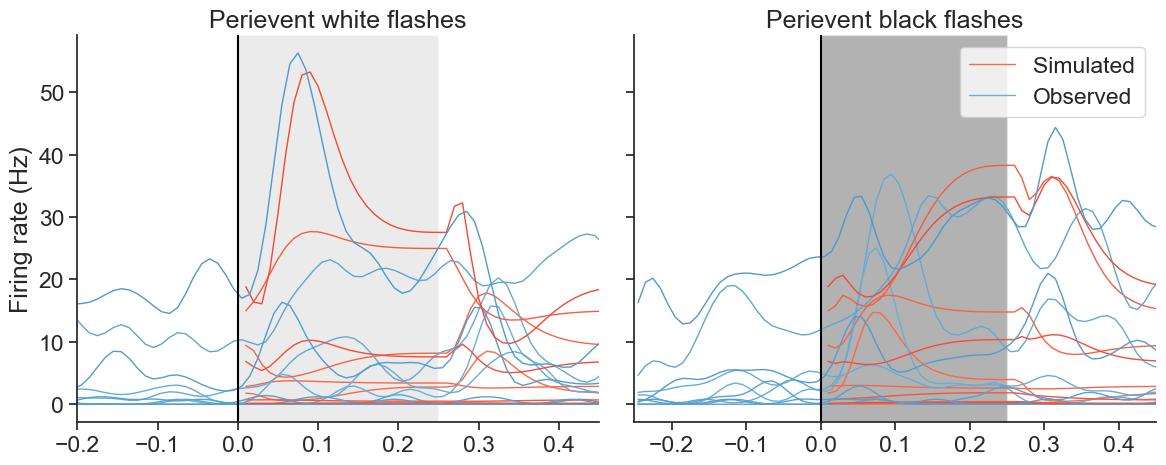

In [41]:
def plot_peri_both(params_obs,
                   params_pred,
                   bin_sz,
                   simulation = False,
                   smoothing = 0.02,
                   n_cells = 30,
                   hist = False):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white_obs, top_neurons_white_obs, peri_black_obs, top_neurons_black_obs = params_obs
    peri_white_pred, top_neurons_white_pred, peri_black_pred, top_neurons_black_pred = params_pred

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    # Set colors obs
    n_lines = len(top_neurons_white_obs)

    cmap_obs = mpl.colormaps['Blues']
    colors_obs = cmap_obs(np.linspace(0.5, 1, n_lines))

    # Set colors sim
    cmap_sim = mpl.colormaps['Reds']
    colors_sim = cmap_sim(np.linspace(0.5, 1, n_lines))

    label_sim_added = False
    label_obs_added = False

    for unit_sim, unit_obs in enumerate(top_neurons_white_obs[:n_cells]):
        if hist:
            peri_u_pred = np.mean(peri_white_pred[21:],axis=1)[:,unit_sim].smooth(smoothing)
        else:
            peri_u_pred = np.mean(peri_white_pred,axis=1)[:,unit_sim]
        if not label_sim_added:
            ax.plot(peri_u_pred, linewidth=1, color = colors_sim[unit_sim], label = "Predicted")
            label_sim_added = True
        else: 
            ax.plot(peri_u_pred, linewidth=1, color = colors_sim[unit_sim])
    
        peri_u_obs = peri_white_obs[unit_obs]
        peri_u_count_obs = peri_u_obs.count(bin_sz)
        peri_u_count_conv_mean_obs = np.mean(peri_u_count_obs, 1).smooth(std=smoothing)
        peri_u_rate_conv_obs = peri_u_count_conv_mean_obs / bin_sz

        if not label_obs_added:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim], label="Observed")
            label_obs_added = True
        else:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim])

    ax.set_xlim(-0.2, 0.450)
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    label_sim_added = False
    label_obs_added = False

    # Plot Black
    ax = axs[1]

    for unit_sim, unit_obs in enumerate(top_neurons_black_obs[:n_cells]):
        if hist:
            peri_u_pred = np.mean(peri_black_pred[21:],axis=1)[:,unit_sim].smooth(smoothing)
        else:
            peri_u_pred = np.mean(peri_black_pred,axis=1)[:,unit_sim]
        if not label_sim_added:
            ax.plot(peri_u_pred, linewidth=1, color = colors_sim[unit_sim], label = "Simulated")
            label_sim_added = True
        else: 
            ax.plot(peri_u_pred, linewidth=1, color = colors_sim[unit_sim])


        peri_u_obs = peri_black_obs[unit_obs]
        peri_u_count_obs = peri_u_obs.count(bin_sz)
        peri_u_count_conv_mean_obs = np.mean(peri_u_count_obs, 1).smooth(std=smoothing)
        peri_u_rate_conv_obs = peri_u_count_conv_mean_obs / bin_sz
        if not label_obs_added:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim], label="Observed")
            label_obs_added = True
        else:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim])

    ax.set_xlim(-0.25, 0.450)
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")

    plt.tight_layout()
    plt.legend()
    plt.show()

plot_peri_both(params_obs_test,
               params_pred,
               bin_size,
               n_cells=10)

It's better for some than for others

add an admonition on why there is no prediction prior to the presentation of stimulus

## Adding history as a new predictor

So far, we have focused on the relatively simple LNP model of spike generation, which is a special case of a GLM. The LNP model has some known shortcomings. For instance, LNP ignores things like refactory periods and other history-dependent features of spiking in a neuron. As we will show in other demos, such spike history filters can be built into GLMs to give more accurate results. We will also show how, if you have recordings from a large population of neurons simultaneously, you can build connections between the neurons into the GLM in the form of coupling filters. This can help answer the degree to which activity is driven primarily by the input X, or by network influences in the population. [from nemos - adapt]

Question: can we use the spiking activity of other neurons to predict the spiking activity of a neuron?

In [42]:
# New basis
hist_bas = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_length, label="count_history"
)
stim_bas = bas

basis = stim_bas + hist_bas

X_hist_train = basis.compute_features(predictors_train["white"], predictors_train["black"], units_counts_train)
X_hist_test = basis.compute_features(predictors_test["white"], predictors_test["black"], units_counts_test)

In [43]:
# Fit with new basis as predictor
# Fitting pop model
reg_strength = 0.01 #This should be checked with cross validation

model_hist = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = reg_strength,
    solver_name="LBFGS", 
    solver_kwargs=dict(tol=10**-12))

model_hist.fit(X_hist_train,units_counts_train)


PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.01,
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

In [44]:
pred_pop = model_hist.predict(X_hist_test)/ bin_size

pred_tsd_pop = nap.TsdFrame(t=units_counts_test.t, d=pred_pop)

why does it fail when I get to .25? for min peri?


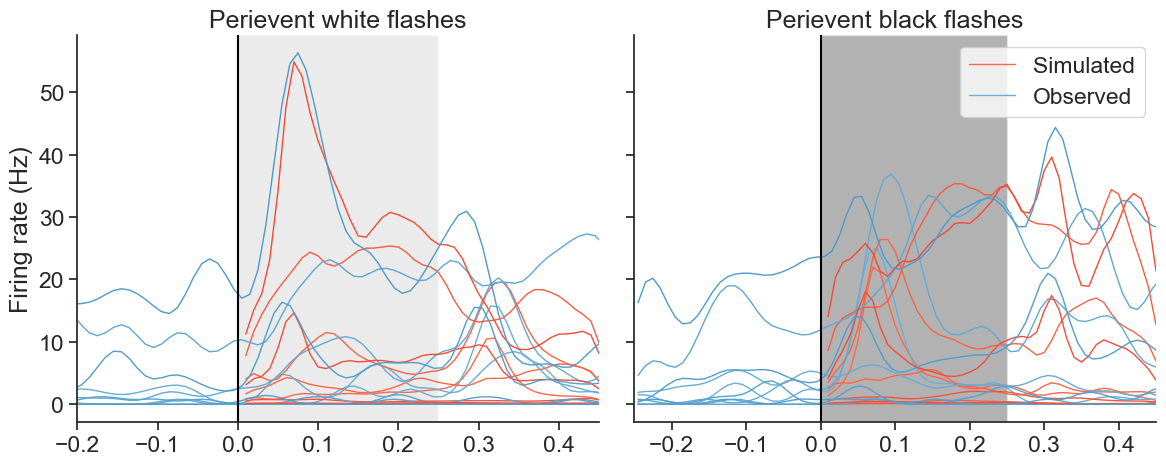

In [45]:
min_peri = -.20
max_peri = .45 # Stimulus presentation is at .25 and lasts until .50

peri_white_pred = nap.compute_perievent_continuous(timeseries = pred_tsd_pop, 
                                        tref = nap.Ts(flashes_test_white.start+.25),
                                        minmax=(min_peri, max_peri)
)  
peri_black_pred =  nap.compute_perievent_continuous(timeseries = pred_tsd_pop, 
                                        tref = nap.Ts(flashes_test_black.start+.25),
                                        minmax=(min_peri, max_peri)
)  

# Excluding last trial from matrix because the last stimulus presented
# was a black one and after it's presented the time series is cut so
# it's all nans
#peri_black_sim_new  = peri_black_pred[:,:-1,:]

params_pred = [peri_white_pred,
              range(peri_white_pred.shape[2]),
              peri_black_pred,
              range(peri_black_pred.shape[2])
              ]

plot_peri_both(params_obs_test,
               params_pred,
               bin_size,
               n_cells=10,
               hist = True)

there is something I am not getting right here

## Evaluate performance

In [46]:
# models : model_hist, model_base
# splits : train, test
# stimuli: black, white, both

# Should be 12 in total

Now we want to see which model has the best performance. When assesing this, it is important that we ask ourselves what is the most reasonable way to do it.

Usually, in linear regression, the $Rˆ2$ measure is used, which is interpreted as the proportion of explained variance by a given model:

$$
\begin{aligned}
R^2 = 1- \frac{\sum_i{(y_i - \hat{y})^2}}{\sum_i{(y_i - \mu)^2}}
\end{aligned}
$$

The numerator in this equation is the variance NOT explained by the model, while the denominator is the total variance of the model. For example, if a given model is perfect at predicting the mean but nothing else, then:

$$
\begin{aligned}
R^2 = 1- \frac{\sum_i{(y_i - \hat{y})^2}}{\sum_i{(y_i - \mu)^2}} = 1 - \frac{\sum_i{(y_i - \mu)^2}}{\sum_i{(y_i - \mu)^2}} = 1 - 1 = 0
\end{aligned}
$$

and the model explains very little of the variance.

Crucially, however, in GLMs, the variance has some characteristics that are incompatible with regular linear regression. In particular:
1. GLMs do not meet the homoscedasticity assumption necessary for linear regression (and $Rˆ2$ interpretation) to make sense. This assumption describes a situation in which the error term is the same across all samples; i.e. constant variance. In GLMs, the variance is not constant! In particular with LNP models, the variance is actually the same as the mean!
2. The $R^2$ captures the variance explained when there is a linear relationship between the observations and the predictor. However, in GLMs, the non-linearity sets a non-linear mapping between the predictors and the mean of the observations. Because of that, the variance explained interpretation does not hold either.




In [55]:
def evaluate_model(model, X, y, label, dataset_type):
    score = model.score(X, y, score_type='pseudo-r2-McFadden')
    full_label = f"{label} ({dataset_type})"
    print(f"{full_label} score: {score:.4f}")
    return full_label, score, dataset_type

def evaluate_models(models, X_sets, y_sets, dataset_label, results):
    for model_name, model in models.items():
        X = X_sets[model_name]
        y = y_sets
        label = f"{model_name} model {dataset_label}"
        results.append(evaluate_model(model, X, y, label, dataset_label))

def evaluate_models_by_color(models, X_sets, y_sets, flashes_color, color,dataset_type, results):
    for model_name, model in models.items():
        X = X_sets[model_name].restrict(flashes_color)
        y = y_sets.restrict(flashes_color)
        label = f"{color} {model_name} model"
        results.append(evaluate_model(model, X, y, label, dataset_type))

# Store all results
all_results = []

# Define model dictionary
models = {
    "base": model_base,
    "hist": model_hist
}

# Evaluate full sets 
# On train data
evaluate_models(models, 
                {"base": X_train, "hist": X_hist_train}, 
                units_counts_train, 
                "train", 
                all_results)

# On test data
evaluate_models(models, 
                {"base": X_test, "hist": X_hist_test}, 
                units_counts_test, 
                "test", 
                all_results)

# Evaluate by color
# Evaluate white on train set
evaluate_models_by_color(models,
                {"base": X_train, "hist": X_hist_train}, 
                units_counts_train, 
                flashes_train_white, 
                "white", 
                "train", 
                all_results

)

# Evaluate black on train set
evaluate_models_by_color(models, 
                         {"base": X_train, "hist": X_hist_train}, 
                         units_counts_train, 
                         flashes_train_black, 
                         "black", 
                         "train", 
                         all_results)

# Evaluate white on test set
evaluate_models_by_color(models, 
                         {"base": X_test, 
                          "hist": X_hist_test}, 
                          units_counts_test, 
                          flashes_test_white, "white", 
                          "test", 
                          all_results)

# Evaluate black on test set
evaluate_models_by_color(models, 
                         {"base": X_test, "hist": X_hist_test}, 
                         units_counts_test, 
                         flashes_test_black, 
                         "black", 
                         "test", 
                         all_results)

# Get best models
best_train = max([r for r in all_results if r[2] == "train"], key=lambda x: x[1])
best_test = max([r for r in all_results if r[2] == "test"], key=lambda x: x[1])

print(f"\nBest TRAIN model: {best_train[0]} with score {best_train[1]:.4f}")
print(f"Best TEST model:  {best_test[0]} with score {best_test[1]:.4f}")


base model train (train) score: 0.0822
hist model train (train) score: 0.1921
base model test (test) score: 0.0707
hist model test (test) score: 0.1110
white base model (train) score: 0.0465
white hist model (train) score: 0.1466
black base model (train) score: 0.0747
black hist model (train) score: 0.1946
white base model (test) score: 0.0357
white hist model (test) score: 0.0801
black base model (test) score: 0.0678
black hist model (test) score: 0.1066

Best TRAIN model: black hist model (train) with score 0.1946
Best TEST model:  hist model test (test) with score 0.1110


### References

### Delete later

<div class="admonition info">
<p class="admonition-title">Resources</p>
<p>
If you would like to learn more in depth about GLMs, you can refer to:

<p>

- [Nemos GLM tutorial](https://nemos.readthedocs.io/en/latest/background/plot_00_conceptual_intro.html): for a bit more detailed explanation of all the components of a GLM within the nemos framework, as well as some nice visualizations of all the steps of the input transformation!</p>


</p>
</div>


##### ----
Formally, a GLM is a model for which $y$ is a non-linear function of a linear combination of the input variables so that

$y = f(wx+w_0)$,

where $f(.)$ is known as the activation function in machine learning literature and $f^{-1}(.)$ is known as the link function in statistics [(Bishop, 2009)](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).



Pending:
- Present functions in a way that makes logical sense with the rest of the code
- Comment all functions
- Write explanations in markdown for all steps
- Find citations
- Revise again that the current way of storing stimuli for modeling (np.array) is indeed the best one
- Update requirements
- Make id's consistent between units
- For perievents: maybe split neurons by firing rate? that would allow for the smaller firing rate ones not to be lost when compared to the large firing rate ones
- Add learning objectives
- Add estimated time of completion
- Add self-reflection questions (ideas - limitations for this model?)
- Fix admonitions
- Change image source to actual image source
- Add more resources
- check all titles are uniform in terms of caps
- improve responsiveness explanation/notation
- Should I z-score firing rates so its easier to compare? in single unit raster
- Add smoothing to plotting added to hist!!!
- Add single cell prediction perievent